In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os


In [2]:
import joblib
import pandas as pd

data_ki = joblib.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/dataset/ki/ki_with_features.joblib')
data_ki.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,log10ki_mean,metabolite_features,protein_features
0,MHTKGPTPQQHDGSALRIGIVHARWNETIIEPLLAGTKAKLLACGV...,uniprot_search,A0A6P8BCR9,O=c1n(C[C@H](O)[C@H](O)[C@H](O)CO)c2nc(O)nc(O)...,0.000002,2.5.1.78,-5.698970,-5.698970,"[0.17249086, -0.23665705, -0.11737049, -0.0940...","[0.026722027, -0.06119407, 0.041440543, -0.109..."
1,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,brenda,P00915,CN1CCN(C(=O)c2ccc(S(N)(=O)=O)cc2)[C@@H](Cc2ccc...,0.000707,4.2.1.1,-3.150581,-3.150581,"[0.4240491, 0.28231123, 0.2642891, -0.7667821,...","[-0.029181704, -0.12635791, 0.10866662, 0.0339..."
2,MLDDIRGFMNTFSETMFMDVINYSLTRDRYDSVFLQRQNYRDLGQL...,brenda,Q9HLD0,C[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O...,0.002990,3.2.1.20,-2.524329,-2.524329,"[0.50005734, 0.3923428, 0.064121775, -0.635894...","[0.02874529, -0.17312695, -0.0026887748, 0.035..."
3,MKLMENIFDLAKANKKKIVLAEGEEERNIRASEEIIKDGIADIILV...,uniprot_search,A0A1L5F6Z9,CCN=C(O)CCN=C(O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O...,0.020000,2.3.1.8,-1.698970,-1.698970,"[0.28353548, 0.018489605, -0.5459905, -0.34693...","[-0.06555556, 0.04763434, 0.031432115, 0.17143..."
4,MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYI...,sabio,P28796,CC(N)C(=O)O,24.500000,4.1.99.1,1.389166,1.419631,"[0.051456872, 0.35619217, 0.10593035, -1.04098...","[0.049294557, -0.043596543, 0.0546125, 0.35600..."


In [3]:
data_ki.rename(columns={'log10ki_mean':'label'},inplace=True)
data_ki.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,label,metabolite_features,protein_features
0,MHTKGPTPQQHDGSALRIGIVHARWNETIIEPLLAGTKAKLLACGV...,uniprot_search,A0A6P8BCR9,O=c1n(C[C@H](O)[C@H](O)[C@H](O)CO)c2nc(O)nc(O)...,0.000002,2.5.1.78,-5.698970,-5.698970,"[0.17249086, -0.23665705, -0.11737049, -0.0940...","[0.026722027, -0.06119407, 0.041440543, -0.109..."
1,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,brenda,P00915,CN1CCN(C(=O)c2ccc(S(N)(=O)=O)cc2)[C@@H](Cc2ccc...,0.000707,4.2.1.1,-3.150581,-3.150581,"[0.4240491, 0.28231123, 0.2642891, -0.7667821,...","[-0.029181704, -0.12635791, 0.10866662, 0.0339..."
2,MLDDIRGFMNTFSETMFMDVINYSLTRDRYDSVFLQRQNYRDLGQL...,brenda,Q9HLD0,C[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O...,0.002990,3.2.1.20,-2.524329,-2.524329,"[0.50005734, 0.3923428, 0.064121775, -0.635894...","[0.02874529, -0.17312695, -0.0026887748, 0.035..."
3,MKLMENIFDLAKANKKKIVLAEGEEERNIRASEEIIKDGIADIILV...,uniprot_search,A0A1L5F6Z9,CCN=C(O)CCN=C(O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O...,0.020000,2.3.1.8,-1.698970,-1.698970,"[0.28353548, 0.018489605, -0.5459905, -0.34693...","[-0.06555556, 0.04763434, 0.031432115, 0.17143..."
4,MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYI...,sabio,P28796,CC(N)C(=O)O,24.500000,4.1.99.1,1.389166,1.419631,"[0.051456872, 0.35619217, 0.10593035, -1.04098...","[0.049294557, -0.043596543, 0.0546125, 0.35600..."


In [4]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [5]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data_ki, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define MLP Model for Regression
class MLPRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, hidden_dim=1):
        super(MLPRegressor, self).__init__()

        self.mol_encoder = nn.Linear(mol_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        
        # norm layer + Dropout
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)

        # hidden layer + output layer
        self.hidden = nn.Linear(hidden_dim * 2, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, 1)

        self.activation = nn.ReLU()

    def forward(self, mol_input, protein_input):
        # Reshape to (B, 1, L) for Conv1d
        mol_embedding = self.activation(self.mol_encoder(mol_input))
        protein_embedding = self.activation(self.protein_encoder(protein_input))

        # Concatenate + Normalize + Dropout
        combined = torch.cat((mol_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Hidden → Regress
        hidden_out = self.activation(self.hidden(combined))
        output = self.regressor(hidden_out)

        return output.squeeze(1)


In [7]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr


train_history = pd.DataFrame(columns=[  'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
model = MLPRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim,hidden_dim=512)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(mol_features, protein_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))



    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(mol_features, protein_features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)




Training Epoch 1: 100%|██████████| 261/261 [00:02<00:00, 117.69it/s]
/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_17615/3008050676.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Train Loss: 2.7302, Train MSE: 2.7300, Train MAE: 1.3059
Epoch 0 - Validation Loss: 2.4800, Validation MSE: 2.4812, Validation MAE: 1.2270


Training Epoch 11: 100%|██████████| 261/261 [00:01<00:00, 131.96it/s]


Epoch 10 - Train Loss: 1.5002, Train MSE: 1.5003, Train MAE: 0.9514
Epoch 10 - Validation Loss: 1.8826, Validation MSE: 1.8836, Validation MAE: 1.0546


Training Epoch 21: 100%|██████████| 261/261 [00:01<00:00, 134.22it/s]


Epoch 20 - Train Loss: 1.0730, Train MSE: 1.0731, Train MAE: 0.7982
Epoch 20 - Validation Loss: 1.7056, Validation MSE: 1.7070, Validation MAE: 0.9950


Training Epoch 31: 100%|██████████| 261/261 [00:01<00:00, 135.31it/s]


Epoch 30 - Train Loss: 0.8156, Train MSE: 0.8155, Train MAE: 0.6950
Epoch 30 - Validation Loss: 1.6958, Validation MSE: 1.6966, Validation MAE: 0.9835


Training Epoch 41: 100%|██████████| 261/261 [00:01<00:00, 139.13it/s]


Epoch 40 - Train Loss: 0.6568, Train MSE: 0.6568, Train MAE: 0.6204
Epoch 40 - Validation Loss: 1.7086, Validation MSE: 1.7100, Validation MAE: 0.9828


Training Epoch 51: 100%|██████████| 261/261 [00:02<00:00, 127.98it/s]


Epoch 50 - Train Loss: 0.5558, Train MSE: 0.5559, Train MAE: 0.5701
Epoch 50 - Validation Loss: 1.6707, Validation MSE: 1.6721, Validation MAE: 0.9537


Training Epoch 61: 100%|██████████| 261/261 [00:02<00:00, 128.77it/s]


Epoch 60 - Train Loss: 0.4657, Train MSE: 0.4657, Train MAE: 0.5227
Epoch 60 - Validation Loss: 1.6701, Validation MSE: 1.6713, Validation MAE: 0.9524


Training Epoch 71: 100%|██████████| 261/261 [00:01<00:00, 131.53it/s]


Epoch 70 - Train Loss: 0.4299, Train MSE: 0.4299, Train MAE: 0.5035
Epoch 70 - Validation Loss: 1.6438, Validation MSE: 1.6451, Validation MAE: 0.9471


Training Epoch 81: 100%|██████████| 261/261 [00:01<00:00, 132.26it/s]


Epoch 80 - Train Loss: 0.3754, Train MSE: 0.3754, Train MAE: 0.4685
Epoch 80 - Validation Loss: 1.5795, Validation MSE: 1.5810, Validation MAE: 0.9207


Training Epoch 91: 100%|██████████| 261/261 [00:02<00:00, 114.14it/s]


Epoch 90 - Train Loss: 0.3499, Train MSE: 0.3499, Train MAE: 0.4500
Epoch 90 - Validation Loss: 1.5621, Validation MSE: 1.5634, Validation MAE: 0.9203


Training Epoch 101: 100%|██████████| 261/261 [00:01<00:00, 131.27it/s]


Epoch 100 - Train Loss: 0.3258, Train MSE: 0.3257, Train MAE: 0.4355
Epoch 100 - Validation Loss: 1.6291, Validation MSE: 1.6306, Validation MAE: 0.9297


Training Epoch 111: 100%|██████████| 261/261 [00:01<00:00, 132.98it/s]


Epoch 110 - Train Loss: 0.3043, Train MSE: 0.3043, Train MAE: 0.4214
Epoch 110 - Validation Loss: 1.6007, Validation MSE: 1.6022, Validation MAE: 0.9215


Training Epoch 121: 100%|██████████| 261/261 [00:02<00:00, 94.62it/s]


Epoch 120 - Train Loss: 0.2812, Train MSE: 0.2812, Train MAE: 0.4049
Epoch 120 - Validation Loss: 1.5903, Validation MSE: 1.5915, Validation MAE: 0.9222


Training Epoch 131: 100%|██████████| 261/261 [15:41<00:00,  3.61s/it]


Epoch 130 - Train Loss: 0.2704, Train MSE: 0.2704, Train MAE: 0.3935
Epoch 130 - Validation Loss: 1.5968, Validation MSE: 1.5980, Validation MAE: 0.9225


Training Epoch 141: 100%|██████████| 261/261 [00:03<00:00, 80.41it/s]


Epoch 140 - Train Loss: 0.2552, Train MSE: 0.2552, Train MAE: 0.3853
Epoch 140 - Validation Loss: 1.6068, Validation MSE: 1.6084, Validation MAE: 0.9201


Training Epoch 151: 100%|██████████| 261/261 [00:03<00:00, 85.92it/s]


Epoch 150 - Train Loss: 0.2466, Train MSE: 0.2466, Train MAE: 0.3775
Epoch 150 - Validation Loss: 1.6322, Validation MSE: 1.6337, Validation MAE: 0.9254


Training Epoch 161: 100%|██████████| 261/261 [00:03<00:00, 78.43it/s]


Epoch 160 - Train Loss: 0.2330, Train MSE: 0.2331, Train MAE: 0.3650
Epoch 160 - Validation Loss: 1.6044, Validation MSE: 1.6059, Validation MAE: 0.9173


Training Epoch 171: 100%|██████████| 261/261 [00:01<00:00, 137.92it/s]


Epoch 170 - Train Loss: 0.2271, Train MSE: 0.2272, Train MAE: 0.3582
Epoch 170 - Validation Loss: 1.6088, Validation MSE: 1.6101, Validation MAE: 0.9204


Training Epoch 181: 100%|██████████| 261/261 [00:02<00:00, 128.81it/s]


Epoch 180 - Train Loss: 0.2162, Train MSE: 0.2162, Train MAE: 0.3496
Epoch 180 - Validation Loss: 1.5737, Validation MSE: 1.5749, Validation MAE: 0.9120


Training Epoch 191: 100%|██████████| 261/261 [00:01<00:00, 136.64it/s]


Epoch 190 - Train Loss: 0.2066, Train MSE: 0.2066, Train MAE: 0.3444
Epoch 190 - Validation Loss: 1.5853, Validation MSE: 1.5867, Validation MAE: 0.9125


Training Epoch 201: 100%|██████████| 261/261 [00:02<00:00, 107.72it/s]


Epoch 200 - Train Loss: 0.2055, Train MSE: 0.2055, Train MAE: 0.3397
Epoch 200 - Validation Loss: 1.5512, Validation MSE: 1.5527, Validation MAE: 0.9022


Training Epoch 211: 100%|██████████| 261/261 [00:02<00:00, 116.58it/s]


Epoch 210 - Train Loss: 0.1917, Train MSE: 0.1917, Train MAE: 0.3278
Epoch 210 - Validation Loss: 1.5786, Validation MSE: 1.5801, Validation MAE: 0.9078


Training Epoch 221: 100%|██████████| 261/261 [00:01<00:00, 132.67it/s]


Epoch 220 - Train Loss: 0.1825, Train MSE: 0.1825, Train MAE: 0.3201
Epoch 220 - Validation Loss: 1.5659, Validation MSE: 1.5671, Validation MAE: 0.9065


Training Epoch 231: 100%|██████████| 261/261 [00:02<00:00, 129.07it/s]


Epoch 230 - Train Loss: 0.1826, Train MSE: 0.1826, Train MAE: 0.3224
Epoch 230 - Validation Loss: 1.5589, Validation MSE: 1.5603, Validation MAE: 0.9036


Training Epoch 241: 100%|██████████| 261/261 [00:02<00:00, 125.23it/s]


Epoch 240 - Train Loss: 0.1749, Train MSE: 0.1749, Train MAE: 0.3169
Epoch 240 - Validation Loss: 1.5694, Validation MSE: 1.5708, Validation MAE: 0.9094


Training Epoch 251: 100%|██████████| 261/261 [00:02<00:00, 119.49it/s]


Epoch 250 - Train Loss: 0.1663, Train MSE: 0.1663, Train MAE: 0.3078
Epoch 250 - Validation Loss: 1.5937, Validation MSE: 1.5950, Validation MAE: 0.9169


Training Epoch 261: 100%|██████████| 261/261 [00:02<00:00, 118.91it/s]


Epoch 260 - Train Loss: 0.1735, Train MSE: 0.1735, Train MAE: 0.3120
Epoch 260 - Validation Loss: 1.5497, Validation MSE: 1.5511, Validation MAE: 0.9046


Training Epoch 271: 100%|██████████| 261/261 [00:02<00:00, 112.60it/s]


Epoch 270 - Train Loss: 0.1602, Train MSE: 0.1603, Train MAE: 0.3021
Epoch 270 - Validation Loss: 1.5397, Validation MSE: 1.5412, Validation MAE: 0.8968


Training Epoch 281: 100%|██████████| 261/261 [00:02<00:00, 115.94it/s]


Epoch 280 - Train Loss: 0.1601, Train MSE: 0.1601, Train MAE: 0.3010
Epoch 280 - Validation Loss: 1.5503, Validation MSE: 1.5517, Validation MAE: 0.8998


Training Epoch 291: 100%|██████████| 261/261 [00:02<00:00, 127.43it/s]


Epoch 290 - Train Loss: 0.1530, Train MSE: 0.1530, Train MAE: 0.2933
Epoch 290 - Validation Loss: 1.5475, Validation MSE: 1.5491, Validation MAE: 0.9005


Training Epoch 301: 100%|██████████| 261/261 [00:02<00:00, 120.90it/s]


Epoch 300 - Train Loss: 0.1467, Train MSE: 0.1467, Train MAE: 0.2886
Epoch 300 - Validation Loss: 1.5500, Validation MSE: 1.5516, Validation MAE: 0.8977


Training Epoch 311: 100%|██████████| 261/261 [00:02<00:00, 109.72it/s]


Epoch 310 - Train Loss: 0.1499, Train MSE: 0.1499, Train MAE: 0.2883
Epoch 310 - Validation Loss: 1.5421, Validation MSE: 1.5436, Validation MAE: 0.8987


Training Epoch 321: 100%|██████████| 261/261 [00:02<00:00, 116.90it/s]


Epoch 320 - Train Loss: 0.1460, Train MSE: 0.1460, Train MAE: 0.2844
Epoch 320 - Validation Loss: 1.5355, Validation MSE: 1.5371, Validation MAE: 0.8894


Training Epoch 331: 100%|██████████| 261/261 [00:02<00:00, 118.44it/s]


Epoch 330 - Train Loss: 0.1417, Train MSE: 0.1417, Train MAE: 0.2814
Epoch 330 - Validation Loss: 1.5269, Validation MSE: 1.5283, Validation MAE: 0.8948


Training Epoch 341: 100%|██████████| 261/261 [00:05<00:00, 48.45it/s]


Epoch 340 - Train Loss: 0.1385, Train MSE: 0.1384, Train MAE: 0.2793
Epoch 340 - Validation Loss: 1.5593, Validation MSE: 1.5609, Validation MAE: 0.9044


Training Epoch 351: 100%|██████████| 261/261 [00:05<00:00, 49.21it/s]


Epoch 350 - Train Loss: 0.1419, Train MSE: 0.1419, Train MAE: 0.2819
Epoch 350 - Validation Loss: 1.5249, Validation MSE: 1.5263, Validation MAE: 0.8866


Training Epoch 361: 100%|██████████| 261/261 [00:02<00:00, 94.61it/s] 


Epoch 360 - Train Loss: 0.1367, Train MSE: 0.1367, Train MAE: 0.2761
Epoch 360 - Validation Loss: 1.5073, Validation MSE: 1.5088, Validation MAE: 0.8884


Training Epoch 371: 100%|██████████| 261/261 [00:03<00:00, 84.53it/s]


Epoch 370 - Train Loss: 0.1362, Train MSE: 0.1362, Train MAE: 0.2737
Epoch 370 - Validation Loss: 1.5261, Validation MSE: 1.5274, Validation MAE: 0.8937


Training Epoch 381: 100%|██████████| 261/261 [00:03<00:00, 67.52it/s]


Epoch 380 - Train Loss: 0.1255, Train MSE: 0.1255, Train MAE: 0.2642
Epoch 380 - Validation Loss: 1.5345, Validation MSE: 1.5359, Validation MAE: 0.8920


Training Epoch 391: 100%|██████████| 261/261 [00:02<00:00, 89.01it/s]


Epoch 390 - Train Loss: 0.1260, Train MSE: 0.1260, Train MAE: 0.2641
Epoch 390 - Validation Loss: 1.5255, Validation MSE: 1.5271, Validation MAE: 0.8876


Training Epoch 401: 100%|██████████| 261/261 [00:03<00:00, 78.82it/s]


Epoch 400 - Train Loss: 0.1252, Train MSE: 0.1252, Train MAE: 0.2637
Epoch 400 - Validation Loss: 1.5392, Validation MSE: 1.5407, Validation MAE: 0.9019


Training Epoch 411: 100%|██████████| 261/261 [00:04<00:00, 64.56it/s]


Epoch 410 - Train Loss: 0.1241, Train MSE: 0.1241, Train MAE: 0.2609
Epoch 410 - Validation Loss: 1.5347, Validation MSE: 1.5361, Validation MAE: 0.8963


Training Epoch 421: 100%|██████████| 261/261 [00:04<00:00, 64.77it/s]


Epoch 420 - Train Loss: 0.1204, Train MSE: 0.1204, Train MAE: 0.2577
Epoch 420 - Validation Loss: 1.5289, Validation MSE: 1.5304, Validation MAE: 0.8898


Training Epoch 431: 100%|██████████| 261/261 [00:03<00:00, 68.84it/s]


Epoch 430 - Train Loss: 0.1204, Train MSE: 0.1205, Train MAE: 0.2566
Epoch 430 - Validation Loss: 1.5271, Validation MSE: 1.5284, Validation MAE: 0.8932


Training Epoch 441: 100%|██████████| 261/261 [00:03<00:00, 70.36it/s]


Epoch 440 - Train Loss: 0.1209, Train MSE: 0.1209, Train MAE: 0.2563
Epoch 440 - Validation Loss: 1.5279, Validation MSE: 1.5295, Validation MAE: 0.8928


Training Epoch 451: 100%|██████████| 261/261 [00:03<00:00, 71.16it/s]


Epoch 450 - Train Loss: 0.1172, Train MSE: 0.1172, Train MAE: 0.2535
Epoch 450 - Validation Loss: 1.5579, Validation MSE: 1.5593, Validation MAE: 0.9045


Training Epoch 461: 100%|██████████| 261/261 [00:05<00:00, 45.18it/s]


Epoch 460 - Train Loss: 0.1132, Train MSE: 0.1132, Train MAE: 0.2486
Epoch 460 - Validation Loss: 1.5371, Validation MSE: 1.5386, Validation MAE: 0.8939


Training Epoch 471: 100%|██████████| 261/261 [00:06<00:00, 42.14it/s]


Epoch 470 - Train Loss: 0.1121, Train MSE: 0.1121, Train MAE: 0.2474
Epoch 470 - Validation Loss: 1.5464, Validation MSE: 1.5479, Validation MAE: 0.8998


Training Epoch 481: 100%|██████████| 261/261 [00:05<00:00, 44.97it/s]


Epoch 480 - Train Loss: 0.1143, Train MSE: 0.1143, Train MAE: 0.2489
Epoch 480 - Validation Loss: 1.5434, Validation MSE: 1.5448, Validation MAE: 0.9007


Training Epoch 491: 100%|██████████| 261/261 [00:03<00:00, 69.55it/s]


Epoch 490 - Train Loss: 0.1112, Train MSE: 0.1112, Train MAE: 0.2476
Epoch 490 - Validation Loss: 1.5546, Validation MSE: 1.5561, Validation MAE: 0.8965


Training Epoch 501: 100%|██████████| 261/261 [00:03<00:00, 73.43it/s]


Epoch 500 - Train Loss: 0.1089, Train MSE: 0.1089, Train MAE: 0.2449
Epoch 500 - Validation Loss: 1.5168, Validation MSE: 1.5184, Validation MAE: 0.8925


Training Epoch 511: 100%|██████████| 261/261 [00:03<00:00, 83.26it/s]


Epoch 510 - Train Loss: 0.1086, Train MSE: 0.1086, Train MAE: 0.2433
Epoch 510 - Validation Loss: 1.5483, Validation MSE: 1.5499, Validation MAE: 0.8992


Training Epoch 521: 100%|██████████| 261/261 [00:03<00:00, 79.95it/s]


Epoch 520 - Train Loss: 0.1118, Train MSE: 0.1118, Train MAE: 0.2447
Epoch 520 - Validation Loss: 1.5372, Validation MSE: 1.5387, Validation MAE: 0.8966


Training Epoch 531: 100%|██████████| 261/261 [00:03<00:00, 82.22it/s]


Epoch 530 - Train Loss: 0.1019, Train MSE: 0.1019, Train MAE: 0.2349
Epoch 530 - Validation Loss: 1.5208, Validation MSE: 1.5223, Validation MAE: 0.8923


Training Epoch 541: 100%|██████████| 261/261 [00:03<00:00, 83.32it/s]


Epoch 540 - Train Loss: 0.1059, Train MSE: 0.1059, Train MAE: 0.2378
Epoch 540 - Validation Loss: 1.5364, Validation MSE: 1.5379, Validation MAE: 0.8964


Training Epoch 551: 100%|██████████| 261/261 [00:03<00:00, 83.23it/s]


Epoch 550 - Train Loss: 0.1023, Train MSE: 0.1023, Train MAE: 0.2358
Epoch 550 - Validation Loss: 1.5604, Validation MSE: 1.5618, Validation MAE: 0.9003


Training Epoch 561: 100%|██████████| 261/261 [00:03<00:00, 83.71it/s]


Epoch 560 - Train Loss: 0.0991, Train MSE: 0.0991, Train MAE: 0.2316
Epoch 560 - Validation Loss: 1.5354, Validation MSE: 1.5368, Validation MAE: 0.8944


Training Epoch 571: 100%|██████████| 261/261 [00:03<00:00, 86.15it/s]


Epoch 570 - Train Loss: 0.0976, Train MSE: 0.0976, Train MAE: 0.2307
Epoch 570 - Validation Loss: 1.5464, Validation MSE: 1.5480, Validation MAE: 0.8954


Training Epoch 581: 100%|██████████| 261/261 [00:03<00:00, 83.24it/s]


Epoch 580 - Train Loss: 0.0962, Train MSE: 0.0962, Train MAE: 0.2296
Epoch 580 - Validation Loss: 1.5220, Validation MSE: 1.5234, Validation MAE: 0.8897


Training Epoch 591: 100%|██████████| 261/261 [00:02<00:00, 87.04it/s]


Epoch 590 - Train Loss: 0.0977, Train MSE: 0.0977, Train MAE: 0.2281
Epoch 590 - Validation Loss: 1.5194, Validation MSE: 1.5209, Validation MAE: 0.8889


Training Epoch 601: 100%|██████████| 261/261 [00:03<00:00, 84.37it/s]


Epoch 600 - Train Loss: 0.0982, Train MSE: 0.0982, Train MAE: 0.2296
Epoch 600 - Validation Loss: 1.5204, Validation MSE: 1.5218, Validation MAE: 0.8925


Training Epoch 611: 100%|██████████| 261/261 [00:03<00:00, 84.22it/s]


Epoch 610 - Train Loss: 0.0988, Train MSE: 0.0988, Train MAE: 0.2294
Epoch 610 - Validation Loss: 1.5416, Validation MSE: 1.5431, Validation MAE: 0.9014


Training Epoch 621: 100%|██████████| 261/261 [00:03<00:00, 81.60it/s]


Epoch 620 - Train Loss: 0.0924, Train MSE: 0.0924, Train MAE: 0.2228
Epoch 620 - Validation Loss: 1.5331, Validation MSE: 1.5344, Validation MAE: 0.8981


Training Epoch 631: 100%|██████████| 261/261 [00:03<00:00, 79.86it/s]


Epoch 630 - Train Loss: 0.0939, Train MSE: 0.0939, Train MAE: 0.2247
Epoch 630 - Validation Loss: 1.5496, Validation MSE: 1.5509, Validation MAE: 0.8996


Training Epoch 641: 100%|██████████| 261/261 [00:03<00:00, 82.62it/s]


Epoch 640 - Train Loss: 0.0944, Train MSE: 0.0944, Train MAE: 0.2260
Epoch 640 - Validation Loss: 1.5359, Validation MSE: 1.5372, Validation MAE: 0.8936


Training Epoch 651: 100%|██████████| 261/261 [00:03<00:00, 79.17it/s]


Epoch 650 - Train Loss: 0.0915, Train MSE: 0.0915, Train MAE: 0.2205
Epoch 650 - Validation Loss: 1.5245, Validation MSE: 1.5259, Validation MAE: 0.8941


Training Epoch 661: 100%|██████████| 261/261 [00:03<00:00, 82.32it/s]


Epoch 660 - Train Loss: 0.0958, Train MSE: 0.0958, Train MAE: 0.2253
Epoch 660 - Validation Loss: 1.5372, Validation MSE: 1.5387, Validation MAE: 0.8971


Training Epoch 671: 100%|██████████| 261/261 [00:03<00:00, 80.65it/s]


Epoch 670 - Train Loss: 0.0935, Train MSE: 0.0935, Train MAE: 0.2203
Epoch 670 - Validation Loss: 1.5649, Validation MSE: 1.5663, Validation MAE: 0.9053


Training Epoch 681: 100%|██████████| 261/261 [00:03<00:00, 71.37it/s]


Epoch 680 - Train Loss: 0.0908, Train MSE: 0.0908, Train MAE: 0.2199
Epoch 680 - Validation Loss: 1.5542, Validation MSE: 1.5557, Validation MAE: 0.9018


Training Epoch 691: 100%|██████████| 261/261 [00:03<00:00, 85.14it/s]


Epoch 690 - Train Loss: 0.0895, Train MSE: 0.0895, Train MAE: 0.2175
Epoch 690 - Validation Loss: 1.5408, Validation MSE: 1.5423, Validation MAE: 0.8978


Training Epoch 701: 100%|██████████| 261/261 [00:02<00:00, 90.81it/s]


Epoch 700 - Train Loss: 0.0862, Train MSE: 0.0862, Train MAE: 0.2155
Epoch 700 - Validation Loss: 1.5348, Validation MSE: 1.5363, Validation MAE: 0.8917


Training Epoch 711: 100%|██████████| 261/261 [00:02<00:00, 90.07it/s]


Epoch 710 - Train Loss: 0.0879, Train MSE: 0.0879, Train MAE: 0.2169
Epoch 710 - Validation Loss: 1.5422, Validation MSE: 1.5437, Validation MAE: 0.8959


Training Epoch 721: 100%|██████████| 261/261 [00:02<00:00, 91.04it/s]


Epoch 720 - Train Loss: 0.0877, Train MSE: 0.0877, Train MAE: 0.2158
Epoch 720 - Validation Loss: 1.5301, Validation MSE: 1.5316, Validation MAE: 0.8957


Training Epoch 731: 100%|██████████| 261/261 [00:02<00:00, 92.18it/s]


Epoch 730 - Train Loss: 0.0893, Train MSE: 0.0893, Train MAE: 0.2150
Epoch 730 - Validation Loss: 1.5402, Validation MSE: 1.5416, Validation MAE: 0.8953


Training Epoch 741: 100%|██████████| 261/261 [00:02<00:00, 87.67it/s]


Epoch 740 - Train Loss: 0.0853, Train MSE: 0.0852, Train MAE: 0.2139
Epoch 740 - Validation Loss: 1.5175, Validation MSE: 1.5190, Validation MAE: 0.8925


Training Epoch 751: 100%|██████████| 261/261 [00:03<00:00, 83.93it/s]


Epoch 750 - Train Loss: 0.0842, Train MSE: 0.0842, Train MAE: 0.2113
Epoch 750 - Validation Loss: 1.5426, Validation MSE: 1.5441, Validation MAE: 0.8966


Training Epoch 761: 100%|██████████| 261/261 [00:02<00:00, 91.58it/s]


Epoch 760 - Train Loss: 0.0834, Train MSE: 0.0834, Train MAE: 0.2108
Epoch 760 - Validation Loss: 1.5287, Validation MSE: 1.5302, Validation MAE: 0.8963


Training Epoch 771: 100%|██████████| 261/261 [00:03<00:00, 86.86it/s]


Epoch 770 - Train Loss: 0.0841, Train MSE: 0.0841, Train MAE: 0.2117
Epoch 770 - Validation Loss: 1.5220, Validation MSE: 1.5236, Validation MAE: 0.8934


Training Epoch 781: 100%|██████████| 261/261 [00:02<00:00, 91.35it/s]


Epoch 780 - Train Loss: 0.0809, Train MSE: 0.0809, Train MAE: 0.2056
Epoch 780 - Validation Loss: 1.5473, Validation MSE: 1.5488, Validation MAE: 0.8984


Training Epoch 791: 100%|██████████| 261/261 [00:02<00:00, 91.23it/s]


Epoch 790 - Train Loss: 0.0789, Train MSE: 0.0789, Train MAE: 0.2051
Epoch 790 - Validation Loss: 1.5506, Validation MSE: 1.5522, Validation MAE: 0.9047


Training Epoch 801: 100%|██████████| 261/261 [00:02<00:00, 94.20it/s] 


Epoch 800 - Train Loss: 0.0868, Train MSE: 0.0868, Train MAE: 0.2113
Epoch 800 - Validation Loss: 1.5479, Validation MSE: 1.5494, Validation MAE: 0.9011


Training Epoch 811: 100%|██████████| 261/261 [00:02<00:00, 91.07it/s]


Epoch 810 - Train Loss: 0.0827, Train MSE: 0.0827, Train MAE: 0.2094
Epoch 810 - Validation Loss: 1.5326, Validation MSE: 1.5341, Validation MAE: 0.8939


Training Epoch 821: 100%|██████████| 261/261 [00:02<00:00, 93.92it/s]


Epoch 820 - Train Loss: 0.0790, Train MSE: 0.0790, Train MAE: 0.2044
Epoch 820 - Validation Loss: 1.5338, Validation MSE: 1.5353, Validation MAE: 0.8931


Training Epoch 831: 100%|██████████| 261/261 [00:03<00:00, 85.72it/s]


Epoch 830 - Train Loss: 0.0829, Train MSE: 0.0829, Train MAE: 0.2086
Epoch 830 - Validation Loss: 1.5461, Validation MSE: 1.5477, Validation MAE: 0.8958


Training Epoch 841: 100%|██████████| 261/261 [00:02<00:00, 92.43it/s]


Epoch 840 - Train Loss: 0.0796, Train MSE: 0.0796, Train MAE: 0.2040
Epoch 840 - Validation Loss: 1.5503, Validation MSE: 1.5518, Validation MAE: 0.9019


Training Epoch 851: 100%|██████████| 261/261 [00:02<00:00, 91.17it/s]


Epoch 850 - Train Loss: 0.0814, Train MSE: 0.0814, Train MAE: 0.2045
Epoch 850 - Validation Loss: 1.5496, Validation MSE: 1.5511, Validation MAE: 0.9003


Training Epoch 861: 100%|██████████| 261/261 [00:02<00:00, 90.14it/s]


Epoch 860 - Train Loss: 0.0747, Train MSE: 0.0747, Train MAE: 0.1996
Epoch 860 - Validation Loss: 1.5601, Validation MSE: 1.5617, Validation MAE: 0.9029


Training Epoch 871: 100%|██████████| 261/261 [00:02<00:00, 87.90it/s]


Epoch 870 - Train Loss: 0.0782, Train MSE: 0.0783, Train MAE: 0.2025
Epoch 870 - Validation Loss: 1.5400, Validation MSE: 1.5416, Validation MAE: 0.8998


Training Epoch 881: 100%|██████████| 261/261 [00:02<00:00, 91.23it/s]


Epoch 880 - Train Loss: 0.0758, Train MSE: 0.0758, Train MAE: 0.2020
Epoch 880 - Validation Loss: 1.5498, Validation MSE: 1.5514, Validation MAE: 0.8965


Training Epoch 891: 100%|██████████| 261/261 [00:03<00:00, 83.23it/s]


Epoch 890 - Train Loss: 0.0757, Train MSE: 0.0756, Train MAE: 0.1996
Epoch 890 - Validation Loss: 1.5392, Validation MSE: 1.5408, Validation MAE: 0.8969


Training Epoch 901: 100%|██████████| 261/261 [00:04<00:00, 61.75it/s]


Epoch 900 - Train Loss: 0.0773, Train MSE: 0.0773, Train MAE: 0.2037
Epoch 900 - Validation Loss: 1.5219, Validation MSE: 1.5235, Validation MAE: 0.8919


Training Epoch 911: 100%|██████████| 261/261 [00:02<00:00, 90.97it/s] 


Epoch 910 - Train Loss: 0.0744, Train MSE: 0.0744, Train MAE: 0.1989
Epoch 910 - Validation Loss: 1.5247, Validation MSE: 1.5263, Validation MAE: 0.8917


Training Epoch 921: 100%|██████████| 261/261 [00:02<00:00, 94.46it/s]


Epoch 920 - Train Loss: 0.0730, Train MSE: 0.0730, Train MAE: 0.1970
Epoch 920 - Validation Loss: 1.5354, Validation MSE: 1.5370, Validation MAE: 0.8960


Training Epoch 931: 100%|██████████| 261/261 [00:02<00:00, 89.36it/s]


Epoch 930 - Train Loss: 0.0744, Train MSE: 0.0744, Train MAE: 0.1968
Epoch 930 - Validation Loss: 1.5219, Validation MSE: 1.5235, Validation MAE: 0.8918


Training Epoch 941: 100%|██████████| 261/261 [00:02<00:00, 94.79it/s] 


Epoch 940 - Train Loss: 0.0732, Train MSE: 0.0732, Train MAE: 0.1958
Epoch 940 - Validation Loss: 1.5315, Validation MSE: 1.5331, Validation MAE: 0.8938


Training Epoch 951: 100%|██████████| 261/261 [00:03<00:00, 85.29it/s] 


Epoch 950 - Train Loss: 0.0745, Train MSE: 0.0745, Train MAE: 0.1978
Epoch 950 - Validation Loss: 1.5167, Validation MSE: 1.5184, Validation MAE: 0.8912


Training Epoch 961: 100%|██████████| 261/261 [00:02<00:00, 90.95it/s]


Epoch 960 - Train Loss: 0.0715, Train MSE: 0.0715, Train MAE: 0.1932
Epoch 960 - Validation Loss: 1.5363, Validation MSE: 1.5379, Validation MAE: 0.8941


Training Epoch 971: 100%|██████████| 261/261 [00:02<00:00, 90.53it/s]


Epoch 970 - Train Loss: 0.0702, Train MSE: 0.0702, Train MAE: 0.1933
Epoch 970 - Validation Loss: 1.5440, Validation MSE: 1.5455, Validation MAE: 0.8973


Training Epoch 981: 100%|██████████| 261/261 [00:03<00:00, 83.87it/s] 


Epoch 980 - Train Loss: 0.0684, Train MSE: 0.0684, Train MAE: 0.1890
Epoch 980 - Validation Loss: 1.5362, Validation MSE: 1.5377, Validation MAE: 0.8970


Training Epoch 991: 100%|██████████| 261/261 [00:03<00:00, 77.04it/s]


Epoch 990 - Train Loss: 0.0686, Train MSE: 0.0686, Train MAE: 0.1910
Epoch 990 - Validation Loss: 1.5310, Validation MSE: 1.5326, Validation MAE: 0.8937


Training Epoch 1001: 100%|██████████| 261/261 [00:02<00:00, 88.54it/s]


Epoch 1000 - Train Loss: 0.0717, Train MSE: 0.0717, Train MAE: 0.1935
Epoch 1000 - Validation Loss: 1.5447, Validation MSE: 1.5463, Validation MAE: 0.8985


Training Epoch 1011: 100%|██████████| 261/261 [00:03<00:00, 85.72it/s]


Epoch 1010 - Train Loss: 0.0690, Train MSE: 0.0690, Train MAE: 0.1910
Epoch 1010 - Validation Loss: 1.5305, Validation MSE: 1.5321, Validation MAE: 0.8957


Training Epoch 1021: 100%|██████████| 261/261 [00:03<00:00, 85.93it/s]


Epoch 1020 - Train Loss: 0.0719, Train MSE: 0.0719, Train MAE: 0.1929
Epoch 1020 - Validation Loss: 1.5468, Validation MSE: 1.5485, Validation MAE: 0.8922


Training Epoch 1031: 100%|██████████| 261/261 [00:02<00:00, 88.37it/s]


Epoch 1030 - Train Loss: 0.0693, Train MSE: 0.0694, Train MAE: 0.1909
Epoch 1030 - Validation Loss: 1.5410, Validation MSE: 1.5426, Validation MAE: 0.8985


Training Epoch 1041: 100%|██████████| 261/261 [00:02<00:00, 92.54it/s]


Epoch 1040 - Train Loss: 0.0668, Train MSE: 0.0668, Train MAE: 0.1865
Epoch 1040 - Validation Loss: 1.5428, Validation MSE: 1.5444, Validation MAE: 0.8980


Training Epoch 1051: 100%|██████████| 261/261 [00:02<00:00, 87.22it/s]


Epoch 1050 - Train Loss: 0.0682, Train MSE: 0.0682, Train MAE: 0.1878
Epoch 1050 - Validation Loss: 1.5534, Validation MSE: 1.5551, Validation MAE: 0.8992


Training Epoch 1061: 100%|██████████| 261/261 [00:02<00:00, 93.11it/s] 


Epoch 1060 - Train Loss: 0.0683, Train MSE: 0.0683, Train MAE: 0.1874
Epoch 1060 - Validation Loss: 1.5302, Validation MSE: 1.5318, Validation MAE: 0.8954


Training Epoch 1071: 100%|██████████| 261/261 [00:02<00:00, 92.91it/s] 


Epoch 1070 - Train Loss: 0.0676, Train MSE: 0.0676, Train MAE: 0.1876
Epoch 1070 - Validation Loss: 1.5525, Validation MSE: 1.5541, Validation MAE: 0.8945


Training Epoch 1081: 100%|██████████| 261/261 [00:03<00:00, 68.73it/s]


Epoch 1080 - Train Loss: 0.0669, Train MSE: 0.0669, Train MAE: 0.1863
Epoch 1080 - Validation Loss: 1.5373, Validation MSE: 1.5389, Validation MAE: 0.8946


Training Epoch 1091: 100%|██████████| 261/261 [00:02<00:00, 90.83it/s] 


Epoch 1090 - Train Loss: 0.0674, Train MSE: 0.0674, Train MAE: 0.1868
Epoch 1090 - Validation Loss: 1.5605, Validation MSE: 1.5622, Validation MAE: 0.9012


Training Epoch 1101: 100%|██████████| 261/261 [00:02<00:00, 90.08it/s] 


Epoch 1100 - Train Loss: 0.0685, Train MSE: 0.0685, Train MAE: 0.1894
Epoch 1100 - Validation Loss: 1.5231, Validation MSE: 1.5248, Validation MAE: 0.8914


Training Epoch 1111: 100%|██████████| 261/261 [00:03<00:00, 86.54it/s]


Epoch 1110 - Train Loss: 0.0671, Train MSE: 0.0671, Train MAE: 0.1874
Epoch 1110 - Validation Loss: 1.5350, Validation MSE: 1.5366, Validation MAE: 0.8932


Training Epoch 1121: 100%|██████████| 261/261 [00:02<00:00, 93.34it/s] 


Epoch 1120 - Train Loss: 0.0637, Train MSE: 0.0637, Train MAE: 0.1823
Epoch 1120 - Validation Loss: 1.5379, Validation MSE: 1.5396, Validation MAE: 0.8951


Training Epoch 1131: 100%|██████████| 261/261 [00:03<00:00, 82.84it/s]


Epoch 1130 - Train Loss: 0.0655, Train MSE: 0.0655, Train MAE: 0.1862
Epoch 1130 - Validation Loss: 1.5499, Validation MSE: 1.5516, Validation MAE: 0.8958


Training Epoch 1141: 100%|██████████| 261/261 [00:02<00:00, 93.43it/s] 


Epoch 1140 - Train Loss: 0.0651, Train MSE: 0.0651, Train MAE: 0.1830
Epoch 1140 - Validation Loss: 1.5450, Validation MSE: 1.5468, Validation MAE: 0.9002


Training Epoch 1151: 100%|██████████| 261/261 [00:02<00:00, 93.88it/s]


Epoch 1150 - Train Loss: 0.0657, Train MSE: 0.0657, Train MAE: 0.1825
Epoch 1150 - Validation Loss: 1.5415, Validation MSE: 1.5432, Validation MAE: 0.8965


Training Epoch 1161: 100%|██████████| 261/261 [00:03<00:00, 83.90it/s]


Epoch 1160 - Train Loss: 0.0632, Train MSE: 0.0632, Train MAE: 0.1802
Epoch 1160 - Validation Loss: 1.5209, Validation MSE: 1.5226, Validation MAE: 0.8859


Training Epoch 1171: 100%|██████████| 261/261 [00:03<00:00, 86.77it/s]


Epoch 1170 - Train Loss: 0.0633, Train MSE: 0.0633, Train MAE: 0.1814
Epoch 1170 - Validation Loss: 1.5434, Validation MSE: 1.5451, Validation MAE: 0.8921


Training Epoch 1181: 100%|██████████| 261/261 [00:16<00:00, 16.20it/s]


Epoch 1180 - Train Loss: 0.0651, Train MSE: 0.0651, Train MAE: 0.1809
Epoch 1180 - Validation Loss: 1.5361, Validation MSE: 1.5377, Validation MAE: 0.8966


Training Epoch 1191: 100%|██████████| 261/261 [00:02<00:00, 89.46it/s]


Epoch 1190 - Train Loss: 0.0612, Train MSE: 0.0612, Train MAE: 0.1778
Epoch 1190 - Validation Loss: 1.5310, Validation MSE: 1.5327, Validation MAE: 0.8946


Training Epoch 1201: 100%|██████████| 261/261 [00:03<00:00, 85.85it/s]


Epoch 1200 - Train Loss: 0.0620, Train MSE: 0.0619, Train MAE: 0.1798
Epoch 1200 - Validation Loss: 1.5678, Validation MSE: 1.5696, Validation MAE: 0.9024


Training Epoch 1211: 100%|██████████| 261/261 [00:02<00:00, 92.75it/s] 


Epoch 1210 - Train Loss: 0.0620, Train MSE: 0.0620, Train MAE: 0.1791
Epoch 1210 - Validation Loss: 1.5379, Validation MSE: 1.5395, Validation MAE: 0.9010


Training Epoch 1221: 100%|██████████| 261/261 [00:17<00:00, 15.13it/s]


Epoch 1220 - Train Loss: 0.0633, Train MSE: 0.0633, Train MAE: 0.1809
Epoch 1220 - Validation Loss: 1.5431, Validation MSE: 1.5447, Validation MAE: 0.8977


Training Epoch 1231: 100%|██████████| 261/261 [00:04<00:00, 56.74it/s]


Epoch 1230 - Train Loss: 0.0626, Train MSE: 0.0626, Train MAE: 0.1807
Epoch 1230 - Validation Loss: 1.5542, Validation MSE: 1.5558, Validation MAE: 0.9008


Training Epoch 1241: 100%|██████████| 261/261 [00:04<00:00, 55.58it/s]


Epoch 1240 - Train Loss: 0.0618, Train MSE: 0.0618, Train MAE: 0.1784
Epoch 1240 - Validation Loss: 1.5460, Validation MSE: 1.5475, Validation MAE: 0.9003


Training Epoch 1251: 100%|██████████| 261/261 [00:04<00:00, 57.86it/s]


Epoch 1250 - Train Loss: 0.0620, Train MSE: 0.0620, Train MAE: 0.1781
Epoch 1250 - Validation Loss: 1.5684, Validation MSE: 1.5700, Validation MAE: 0.9036


Training Epoch 1261: 100%|██████████| 261/261 [00:04<00:00, 56.98it/s]


Epoch 1260 - Train Loss: 0.0600, Train MSE: 0.0600, Train MAE: 0.1772
Epoch 1260 - Validation Loss: 1.5666, Validation MSE: 1.5683, Validation MAE: 0.9007


Training Epoch 1271: 100%|██████████| 261/261 [00:04<00:00, 55.25it/s]


Epoch 1270 - Train Loss: 0.0582, Train MSE: 0.0582, Train MAE: 0.1734
Epoch 1270 - Validation Loss: 1.5303, Validation MSE: 1.5318, Validation MAE: 0.8931


Training Epoch 1281: 100%|██████████| 261/261 [00:14<00:00, 17.95it/s]


Epoch 1280 - Train Loss: 0.0605, Train MSE: 0.0605, Train MAE: 0.1773
Epoch 1280 - Validation Loss: 1.5472, Validation MSE: 1.5489, Validation MAE: 0.8996


Training Epoch 1291: 100%|██████████| 261/261 [00:13<00:00, 18.75it/s]


Epoch 1290 - Train Loss: 0.0617, Train MSE: 0.0617, Train MAE: 0.1791
Epoch 1290 - Validation Loss: 1.5519, Validation MSE: 1.5535, Validation MAE: 0.9026


Training Epoch 1301: 100%|██████████| 261/261 [00:14<00:00, 18.40it/s]


Epoch 1300 - Train Loss: 0.0610, Train MSE: 0.0610, Train MAE: 0.1779
Epoch 1300 - Validation Loss: 1.5488, Validation MSE: 1.5504, Validation MAE: 0.9014


Training Epoch 1311: 100%|██████████| 261/261 [00:04<00:00, 56.37it/s]


Epoch 1310 - Train Loss: 0.0571, Train MSE: 0.0571, Train MAE: 0.1726
Epoch 1310 - Validation Loss: 1.5369, Validation MSE: 1.5386, Validation MAE: 0.8981


Training Epoch 1321: 100%|██████████| 261/261 [00:04<00:00, 59.92it/s]


Epoch 1320 - Train Loss: 0.0588, Train MSE: 0.0588, Train MAE: 0.1720
Epoch 1320 - Validation Loss: 1.5226, Validation MSE: 1.5242, Validation MAE: 0.8952


Training Epoch 1331: 100%|██████████| 261/261 [00:04<00:00, 59.90it/s]


Epoch 1330 - Train Loss: 0.0590, Train MSE: 0.0590, Train MAE: 0.1739
Epoch 1330 - Validation Loss: 1.5359, Validation MSE: 1.5375, Validation MAE: 0.8982


Training Epoch 1341: 100%|██████████| 261/261 [00:04<00:00, 57.39it/s]


Epoch 1340 - Train Loss: 0.0613, Train MSE: 0.0613, Train MAE: 0.1778
Epoch 1340 - Validation Loss: 1.5517, Validation MSE: 1.5534, Validation MAE: 0.9035


Training Epoch 1351: 100%|██████████| 261/261 [00:04<00:00, 57.77it/s]


Epoch 1350 - Train Loss: 0.0564, Train MSE: 0.0564, Train MAE: 0.1703
Epoch 1350 - Validation Loss: 1.5300, Validation MSE: 1.5318, Validation MAE: 0.8942


Training Epoch 1361: 100%|██████████| 261/261 [00:04<00:00, 59.16it/s]


Epoch 1360 - Train Loss: 0.0580, Train MSE: 0.0580, Train MAE: 0.1715
Epoch 1360 - Validation Loss: 1.5411, Validation MSE: 1.5428, Validation MAE: 0.8996


Training Epoch 1371: 100%|██████████| 261/261 [00:04<00:00, 59.76it/s]


Epoch 1370 - Train Loss: 0.0591, Train MSE: 0.0590, Train MAE: 0.1733
Epoch 1370 - Validation Loss: 1.5375, Validation MSE: 1.5392, Validation MAE: 0.8990


Training Epoch 1381: 100%|██████████| 261/261 [00:04<00:00, 61.66it/s]


Epoch 1380 - Train Loss: 0.0559, Train MSE: 0.0559, Train MAE: 0.1707
Epoch 1380 - Validation Loss: 1.5443, Validation MSE: 1.5459, Validation MAE: 0.9026


Training Epoch 1391: 100%|██████████| 261/261 [00:04<00:00, 55.87it/s]


Epoch 1390 - Train Loss: 0.0573, Train MSE: 0.0573, Train MAE: 0.1722
Epoch 1390 - Validation Loss: 1.5668, Validation MSE: 1.5685, Validation MAE: 0.9072


Training Epoch 1401: 100%|██████████| 261/261 [00:04<00:00, 53.42it/s]


Epoch 1400 - Train Loss: 0.0563, Train MSE: 0.0563, Train MAE: 0.1710
Epoch 1400 - Validation Loss: 1.5303, Validation MSE: 1.5320, Validation MAE: 0.8992


Training Epoch 1411: 100%|██████████| 261/261 [00:04<00:00, 55.49it/s]


Epoch 1410 - Train Loss: 0.0554, Train MSE: 0.0554, Train MAE: 0.1688
Epoch 1410 - Validation Loss: 1.5470, Validation MSE: 1.5488, Validation MAE: 0.9006


Training Epoch 1421: 100%|██████████| 261/261 [00:02<00:00, 88.09it/s]


Epoch 1420 - Train Loss: 0.0551, Train MSE: 0.0551, Train MAE: 0.1672
Epoch 1420 - Validation Loss: 1.5634, Validation MSE: 1.5651, Validation MAE: 0.9082


Training Epoch 1431: 100%|██████████| 261/261 [00:03<00:00, 81.24it/s]


Epoch 1430 - Train Loss: 0.0595, Train MSE: 0.0595, Train MAE: 0.1743
Epoch 1430 - Validation Loss: 1.5556, Validation MSE: 1.5572, Validation MAE: 0.9038


Training Epoch 1441: 100%|██████████| 261/261 [00:02<00:00, 87.25it/s]


Epoch 1440 - Train Loss: 0.0566, Train MSE: 0.0566, Train MAE: 0.1700
Epoch 1440 - Validation Loss: 1.5558, Validation MSE: 1.5575, Validation MAE: 0.9070


Training Epoch 1451: 100%|██████████| 261/261 [00:03<00:00, 86.88it/s]


Epoch 1450 - Train Loss: 0.0557, Train MSE: 0.0557, Train MAE: 0.1681
Epoch 1450 - Validation Loss: 1.5598, Validation MSE: 1.5614, Validation MAE: 0.9057


Training Epoch 1461: 100%|██████████| 261/261 [00:03<00:00, 81.77it/s]


Epoch 1460 - Train Loss: 0.0570, Train MSE: 0.0570, Train MAE: 0.1713
Epoch 1460 - Validation Loss: 1.5269, Validation MSE: 1.5286, Validation MAE: 0.8958


Training Epoch 1471: 100%|██████████| 261/261 [00:02<00:00, 87.86it/s]


Epoch 1470 - Train Loss: 0.0552, Train MSE: 0.0552, Train MAE: 0.1687
Epoch 1470 - Validation Loss: 1.5541, Validation MSE: 1.5557, Validation MAE: 0.9039


Training Epoch 1481: 100%|██████████| 261/261 [00:02<00:00, 87.13it/s]


Epoch 1480 - Train Loss: 0.0552, Train MSE: 0.0552, Train MAE: 0.1690
Epoch 1480 - Validation Loss: 1.5480, Validation MSE: 1.5496, Validation MAE: 0.9045


Training Epoch 1491: 100%|██████████| 261/261 [00:02<00:00, 88.77it/s]


Epoch 1490 - Train Loss: 0.0548, Train MSE: 0.0548, Train MAE: 0.1668
Epoch 1490 - Validation Loss: 1.5421, Validation MSE: 1.5437, Validation MAE: 0.9033


Training Epoch 1501: 100%|██████████| 261/261 [00:02<00:00, 87.54it/s]


Epoch 1500 - Train Loss: 0.0538, Train MSE: 0.0538, Train MAE: 0.1658
Epoch 1500 - Validation Loss: 1.5452, Validation MSE: 1.5470, Validation MAE: 0.9009


Training Epoch 1511: 100%|██████████| 261/261 [00:03<00:00, 86.26it/s]


Epoch 1510 - Train Loss: 0.0533, Train MSE: 0.0533, Train MAE: 0.1652
Epoch 1510 - Validation Loss: 1.5438, Validation MSE: 1.5454, Validation MAE: 0.9007


Training Epoch 1521: 100%|██████████| 261/261 [00:03<00:00, 83.66it/s]


Epoch 1520 - Train Loss: 0.0542, Train MSE: 0.0542, Train MAE: 0.1664
Epoch 1520 - Validation Loss: 1.5223, Validation MSE: 1.5239, Validation MAE: 0.8950


Training Epoch 1531: 100%|██████████| 261/261 [00:02<00:00, 87.79it/s]


Epoch 1530 - Train Loss: 0.0535, Train MSE: 0.0535, Train MAE: 0.1641
Epoch 1530 - Validation Loss: 1.5369, Validation MSE: 1.5386, Validation MAE: 0.8990


Training Epoch 1541: 100%|██████████| 261/261 [00:02<00:00, 88.92it/s]


Epoch 1540 - Train Loss: 0.0530, Train MSE: 0.0530, Train MAE: 0.1650
Epoch 1540 - Validation Loss: 1.5543, Validation MSE: 1.5560, Validation MAE: 0.9010


Training Epoch 1551: 100%|██████████| 261/261 [00:02<00:00, 89.04it/s]


Epoch 1550 - Train Loss: 0.0539, Train MSE: 0.0539, Train MAE: 0.1651
Epoch 1550 - Validation Loss: 1.5494, Validation MSE: 1.5511, Validation MAE: 0.9020


Training Epoch 1561: 100%|██████████| 261/261 [00:03<00:00, 85.58it/s]


Epoch 1560 - Train Loss: 0.0558, Train MSE: 0.0558, Train MAE: 0.1668
Epoch 1560 - Validation Loss: 1.5457, Validation MSE: 1.5474, Validation MAE: 0.9025


Training Epoch 1571: 100%|██████████| 261/261 [00:03<00:00, 86.61it/s]


Epoch 1570 - Train Loss: 0.0554, Train MSE: 0.0554, Train MAE: 0.1678
Epoch 1570 - Validation Loss: 1.5425, Validation MSE: 1.5441, Validation MAE: 0.9016


Training Epoch 1581: 100%|██████████| 261/261 [00:02<00:00, 89.07it/s]


Epoch 1580 - Train Loss: 0.0518, Train MSE: 0.0518, Train MAE: 0.1632
Epoch 1580 - Validation Loss: 1.5359, Validation MSE: 1.5375, Validation MAE: 0.8974


Training Epoch 1591: 100%|██████████| 261/261 [00:04<00:00, 59.84it/s]


Epoch 1590 - Train Loss: 0.0515, Train MSE: 0.0515, Train MAE: 0.1618
Epoch 1590 - Validation Loss: 1.5506, Validation MSE: 1.5522, Validation MAE: 0.9012


Training Epoch 1601: 100%|██████████| 261/261 [00:04<00:00, 59.38it/s]


Epoch 1600 - Train Loss: 0.0530, Train MSE: 0.0530, Train MAE: 0.1620
Epoch 1600 - Validation Loss: 1.5425, Validation MSE: 1.5441, Validation MAE: 0.9023


Training Epoch 1611: 100%|██████████| 261/261 [00:04<00:00, 63.93it/s]


Epoch 1610 - Train Loss: 0.0529, Train MSE: 0.0529, Train MAE: 0.1615
Epoch 1610 - Validation Loss: 1.5432, Validation MSE: 1.5449, Validation MAE: 0.8998


Training Epoch 1621: 100%|██████████| 261/261 [00:04<00:00, 62.50it/s]


Epoch 1620 - Train Loss: 0.0528, Train MSE: 0.0528, Train MAE: 0.1624
Epoch 1620 - Validation Loss: 1.5260, Validation MSE: 1.5276, Validation MAE: 0.8979


Training Epoch 1631: 100%|██████████| 261/261 [00:04<00:00, 63.04it/s]


Epoch 1630 - Train Loss: 0.0525, Train MSE: 0.0525, Train MAE: 0.1620
Epoch 1630 - Validation Loss: 1.5369, Validation MSE: 1.5385, Validation MAE: 0.9033


Training Epoch 1641: 100%|██████████| 261/261 [00:04<00:00, 61.90it/s]


Epoch 1640 - Train Loss: 0.0522, Train MSE: 0.0522, Train MAE: 0.1624
Epoch 1640 - Validation Loss: 1.5381, Validation MSE: 1.5398, Validation MAE: 0.8976


Training Epoch 1651: 100%|██████████| 261/261 [15:27<00:00,  3.55s/it]  


Epoch 1650 - Train Loss: 0.0533, Train MSE: 0.0533, Train MAE: 0.1640
Epoch 1650 - Validation Loss: 1.5458, Validation MSE: 1.5474, Validation MAE: 0.9024


Training Epoch 1661: 100%|██████████| 261/261 [00:04<00:00, 63.14it/s]


Epoch 1660 - Train Loss: 0.0509, Train MSE: 0.0509, Train MAE: 0.1610
Epoch 1660 - Validation Loss: 1.5619, Validation MSE: 1.5635, Validation MAE: 0.9064


Training Epoch 1671: 100%|██████████| 261/261 [00:04<00:00, 61.19it/s]


Epoch 1670 - Train Loss: 0.0514, Train MSE: 0.0514, Train MAE: 0.1616
Epoch 1670 - Validation Loss: 1.5534, Validation MSE: 1.5550, Validation MAE: 0.9036


Training Epoch 1681: 100%|██████████| 261/261 [00:04<00:00, 62.41it/s]


Epoch 1680 - Train Loss: 0.0531, Train MSE: 0.0531, Train MAE: 0.1624
Epoch 1680 - Validation Loss: 1.5523, Validation MSE: 1.5540, Validation MAE: 0.9022


Training Epoch 1691: 100%|██████████| 261/261 [00:04<00:00, 62.18it/s]


Epoch 1690 - Train Loss: 0.0491, Train MSE: 0.0491, Train MAE: 0.1568
Epoch 1690 - Validation Loss: 1.5498, Validation MSE: 1.5515, Validation MAE: 0.9050


Training Epoch 1701: 100%|██████████| 261/261 [00:04<00:00, 59.60it/s]


Epoch 1700 - Train Loss: 0.0499, Train MSE: 0.0499, Train MAE: 0.1575
Epoch 1700 - Validation Loss: 1.5417, Validation MSE: 1.5433, Validation MAE: 0.9023


Training Epoch 1711: 100%|██████████| 261/261 [00:04<00:00, 59.75it/s]


Epoch 1710 - Train Loss: 0.0491, Train MSE: 0.0491, Train MAE: 0.1580
Epoch 1710 - Validation Loss: 1.5504, Validation MSE: 1.5520, Validation MAE: 0.9030


Training Epoch 1721: 100%|██████████| 261/261 [00:04<00:00, 58.68it/s]


Epoch 1720 - Train Loss: 0.0486, Train MSE: 0.0486, Train MAE: 0.1576
Epoch 1720 - Validation Loss: 1.5592, Validation MSE: 1.5609, Validation MAE: 0.9097


Training Epoch 1731: 100%|██████████| 261/261 [00:04<00:00, 63.18it/s]


Epoch 1730 - Train Loss: 0.0498, Train MSE: 0.0498, Train MAE: 0.1575
Epoch 1730 - Validation Loss: 1.5471, Validation MSE: 1.5487, Validation MAE: 0.9046


Training Epoch 1741: 100%|██████████| 261/261 [00:04<00:00, 52.66it/s]


Epoch 1740 - Train Loss: 0.0507, Train MSE: 0.0507, Train MAE: 0.1598
Epoch 1740 - Validation Loss: 1.5617, Validation MSE: 1.5634, Validation MAE: 0.9080


Training Epoch 1751: 100%|██████████| 261/261 [00:04<00:00, 58.71it/s]


Epoch 1750 - Train Loss: 0.0509, Train MSE: 0.0509, Train MAE: 0.1592
Epoch 1750 - Validation Loss: 1.5545, Validation MSE: 1.5562, Validation MAE: 0.9016


Training Epoch 1761: 100%|██████████| 261/261 [00:04<00:00, 58.25it/s]


Epoch 1760 - Train Loss: 0.0490, Train MSE: 0.0490, Train MAE: 0.1576
Epoch 1760 - Validation Loss: 1.5621, Validation MSE: 1.5636, Validation MAE: 0.9087


Training Epoch 1771: 100%|██████████| 261/261 [00:04<00:00, 56.91it/s]


Epoch 1770 - Train Loss: 0.0500, Train MSE: 0.0500, Train MAE: 0.1583
Epoch 1770 - Validation Loss: 1.5475, Validation MSE: 1.5491, Validation MAE: 0.9019


Training Epoch 1781: 100%|██████████| 261/261 [00:04<00:00, 62.58it/s]


Epoch 1780 - Train Loss: 0.0499, Train MSE: 0.0499, Train MAE: 0.1583
Epoch 1780 - Validation Loss: 1.5451, Validation MSE: 1.5467, Validation MAE: 0.9035


Training Epoch 1791: 100%|██████████| 261/261 [00:04<00:00, 58.28it/s]


Epoch 1790 - Train Loss: 0.0470, Train MSE: 0.0470, Train MAE: 0.1548
Epoch 1790 - Validation Loss: 1.5597, Validation MSE: 1.5613, Validation MAE: 0.9055


Training Epoch 1801: 100%|██████████| 261/261 [00:04<00:00, 60.36it/s]


Epoch 1800 - Train Loss: 0.0513, Train MSE: 0.0513, Train MAE: 0.1591
Epoch 1800 - Validation Loss: 1.5328, Validation MSE: 1.5344, Validation MAE: 0.8971


Training Epoch 1811: 100%|██████████| 261/261 [00:04<00:00, 63.95it/s]


Epoch 1810 - Train Loss: 0.0482, Train MSE: 0.0482, Train MAE: 0.1570
Epoch 1810 - Validation Loss: 1.5307, Validation MSE: 1.5323, Validation MAE: 0.8977


Training Epoch 1821: 100%|██████████| 261/261 [00:04<00:00, 62.29it/s]


Epoch 1820 - Train Loss: 0.0494, Train MSE: 0.0494, Train MAE: 0.1561
Epoch 1820 - Validation Loss: 1.5501, Validation MSE: 1.5518, Validation MAE: 0.9024


Training Epoch 1831: 100%|██████████| 261/261 [00:04<00:00, 60.52it/s]


Epoch 1830 - Train Loss: 0.0481, Train MSE: 0.0481, Train MAE: 0.1553
Epoch 1830 - Validation Loss: 1.5363, Validation MSE: 1.5378, Validation MAE: 0.8992


Training Epoch 1841: 100%|██████████| 261/261 [00:04<00:00, 60.96it/s]


Epoch 1840 - Train Loss: 0.0485, Train MSE: 0.0485, Train MAE: 0.1551
Epoch 1840 - Validation Loss: 1.5386, Validation MSE: 1.5402, Validation MAE: 0.9014


Training Epoch 1851: 100%|██████████| 261/261 [00:04<00:00, 61.18it/s]


Epoch 1850 - Train Loss: 0.0493, Train MSE: 0.0493, Train MAE: 0.1573
Epoch 1850 - Validation Loss: 1.5396, Validation MSE: 1.5412, Validation MAE: 0.9034


Training Epoch 1861: 100%|██████████| 261/261 [00:04<00:00, 63.11it/s]


Epoch 1860 - Train Loss: 0.0466, Train MSE: 0.0466, Train MAE: 0.1535
Epoch 1860 - Validation Loss: 1.5461, Validation MSE: 1.5477, Validation MAE: 0.9012


Training Epoch 1871: 100%|██████████| 261/261 [00:04<00:00, 54.60it/s]


Epoch 1870 - Train Loss: 0.0490, Train MSE: 0.0490, Train MAE: 0.1554
Epoch 1870 - Validation Loss: 1.5544, Validation MSE: 1.5561, Validation MAE: 0.9081


Training Epoch 1881: 100%|██████████| 261/261 [00:04<00:00, 57.84it/s]


Epoch 1880 - Train Loss: 0.0474, Train MSE: 0.0474, Train MAE: 0.1548
Epoch 1880 - Validation Loss: 1.5628, Validation MSE: 1.5644, Validation MAE: 0.9078


Training Epoch 1891: 100%|██████████| 261/261 [00:04<00:00, 62.88it/s]


Epoch 1890 - Train Loss: 0.0472, Train MSE: 0.0472, Train MAE: 0.1547
Epoch 1890 - Validation Loss: 1.5442, Validation MSE: 1.5457, Validation MAE: 0.9035


Training Epoch 1901: 100%|██████████| 261/261 [00:04<00:00, 57.55it/s]


Epoch 1900 - Train Loss: 0.0483, Train MSE: 0.0483, Train MAE: 0.1543
Epoch 1900 - Validation Loss: 1.5454, Validation MSE: 1.5470, Validation MAE: 0.9022


Training Epoch 1911: 100%|██████████| 261/261 [00:04<00:00, 64.93it/s]


Epoch 1910 - Train Loss: 0.0474, Train MSE: 0.0474, Train MAE: 0.1545
Epoch 1910 - Validation Loss: 1.5727, Validation MSE: 1.5743, Validation MAE: 0.9106


Training Epoch 1921: 100%|██████████| 261/261 [15:45<00:00,  3.62s/it]  


Epoch 1920 - Train Loss: 0.0480, Train MSE: 0.0480, Train MAE: 0.1549
Epoch 1920 - Validation Loss: 1.5436, Validation MSE: 1.5452, Validation MAE: 0.9031


Training Epoch 1931: 100%|██████████| 261/261 [00:04<00:00, 61.43it/s]


Epoch 1930 - Train Loss: 0.0453, Train MSE: 0.0452, Train MAE: 0.1516
Epoch 1930 - Validation Loss: 1.5567, Validation MSE: 1.5584, Validation MAE: 0.9056


Training Epoch 1941: 100%|██████████| 261/261 [00:03<00:00, 67.53it/s]


Epoch 1940 - Train Loss: 0.0459, Train MSE: 0.0459, Train MAE: 0.1546
Epoch 1940 - Validation Loss: 1.5570, Validation MSE: 1.5588, Validation MAE: 0.9057


Training Epoch 1951: 100%|██████████| 261/261 [00:04<00:00, 62.86it/s]


Epoch 1950 - Train Loss: 0.0475, Train MSE: 0.0475, Train MAE: 0.1534
Epoch 1950 - Validation Loss: 1.5576, Validation MSE: 1.5593, Validation MAE: 0.9072


Training Epoch 1961: 100%|██████████| 261/261 [00:04<00:00, 60.66it/s]


Epoch 1960 - Train Loss: 0.0451, Train MSE: 0.0451, Train MAE: 0.1496
Epoch 1960 - Validation Loss: 1.5573, Validation MSE: 1.5590, Validation MAE: 0.9062


Training Epoch 1971: 100%|██████████| 261/261 [00:04<00:00, 56.44it/s]


Epoch 1970 - Train Loss: 0.0476, Train MSE: 0.0476, Train MAE: 0.1541
Epoch 1970 - Validation Loss: 1.5519, Validation MSE: 1.5535, Validation MAE: 0.9001


Training Epoch 1981: 100%|██████████| 261/261 [00:04<00:00, 64.51it/s]


Epoch 1980 - Train Loss: 0.0475, Train MSE: 0.0475, Train MAE: 0.1532
Epoch 1980 - Validation Loss: 1.5538, Validation MSE: 1.5555, Validation MAE: 0.9059


Training Epoch 1991: 100%|██████████| 261/261 [00:04<00:00, 57.89it/s]


Epoch 1990 - Train Loss: 0.0470, Train MSE: 0.0470, Train MAE: 0.1524
Epoch 1990 - Validation Loss: 1.5393, Validation MSE: 1.5410, Validation MAE: 0.8980


Training Epoch 2000: 100%|██████████| 261/261 [00:04<00:00, 58.69it/s]


Test MSE: 1.6362, Test MAE: 0.9364


In [8]:
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

model = MLPRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim, hidden_dim=512)
model.load_state_dict(torch.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/trained_model/random_split/MLP model_Catpred_Ki.pt'))
model = model.to(device)

In [9]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr
# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))

print(f"Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.9f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}, Test Pearson Correlation: {test_pearson_corr:.4f}, Test Median AE: {test_median_ae:.4f}, Test Explained Variance: {test_explained_var:.4f}")

Test MSE: 1.6362, Test RMSE: 1.279141622, Test MAE: 0.9364, Test R2: 0.5683, Test Pearson Correlation: 0.7560, Test Median AE: 0.6827, Test Explained Variance: 0.5684


In [10]:

def evaluate_model(predictions, labels):
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    pearson_corr, _ = pearsonr(labels, predictions)
    medae = median_absolute_error(labels, predictions)
    evs = explained_variance_score(labels, predictions)

    return mse, rmse, mae, r2, pearson_corr, medae, evs

In [11]:
model.eval()
val_pred, val_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        val_pred.extend(outputs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_mse, val_rmse, val_mae, val_r2, val_pearson_corr, val_median_ae, val_explained_var = evaluate_model(val_pred, val_labels)


In [12]:
model.eval()
train_pred, train_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        train_pred.extend(outputs.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

train_mse, train_rmse, train_mae, train_r2, train_pearson_corr, train_median_ae, train_explained_var = evaluate_model(train_pred, train_labels)

In [13]:
# append the performance to the csv file
df = {
    'Model':['MLP','MLP','MLP'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_mse,val_mse,test_mse],
    'RMSE':[train_rmse,val_rmse,test_rmse],
    'MAE':[train_mae,val_mae,test_mae],
    'R2':[train_r2,val_r2,test_r2],
    'Pearson':[train_pearson_corr,val_pearson_corr,test_pearson_corr],
    'Median_AE':[train_median_ae,val_median_ae,test_median_ae],
    'Explained_VAR':[train_explained_var,val_explained_var,test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/model performance metrics_Catpred_Ki.csv', mode='a', header=False)

In [20]:
# Save the model and training history
save_dir = '/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/trained_model/random_split'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'MLP model_Catpred_Ki.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'MLP optimizer_Catpred_Ki.pt'))

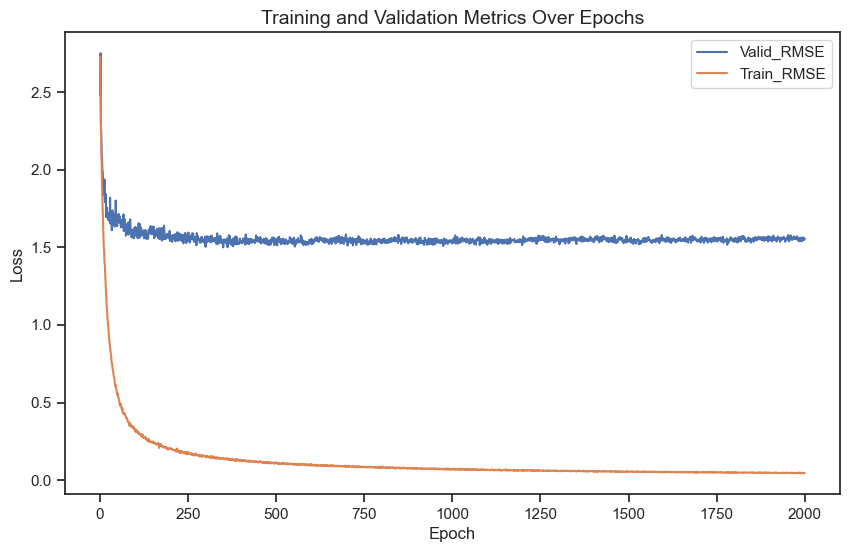

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [22]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.045892,0.045879,0.150911,0.150911,0.988257,0.994111,0.114812,NaN,1.563642,0.910056,0.910056,0.608894,0.780971,0.662533,0.609321,0.988257,1.561946
1996,1997,0.047322,0.047325,0.153436,0.153436,0.987887,0.993925,0.118118,NaN,1.546492,0.903428,0.903428,0.613183,0.784203,0.650546,0.613911,0.987887,1.544790
1997,1998,0.046743,0.046746,0.152805,0.152805,0.988035,0.993999,0.118039,NaN,1.550236,0.902831,0.902831,0.612247,0.784234,0.650334,0.613556,0.988035,1.548560
1998,1999,0.044860,0.044863,0.150929,0.150929,0.988517,0.994242,0.116114,NaN,1.549982,0.903259,0.903259,0.612310,0.783222,0.638044,0.612656,0.988517,1.548296
1999,2000,0.045516,0.045506,0.149358,0.149358,0.988352,0.994159,0.114357,NaN,1.555346,0.904277,0.904277,0.610969,0.782975,0.660453,0.611958,0.988352,1.553677


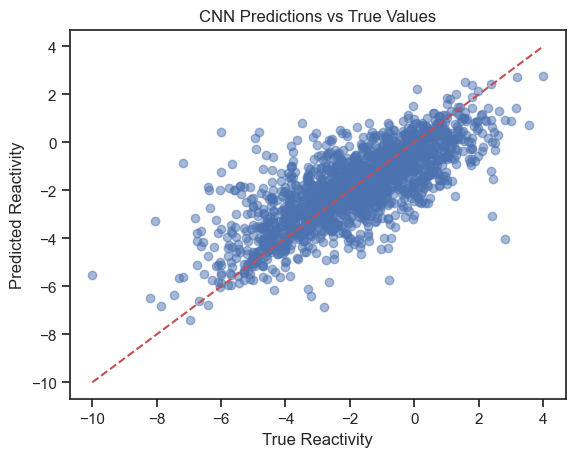

In [23]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("CNN Predictions vs True Values")
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.show()
